<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Создание-разметки" data-toc-modified-id="Создание-разметки-1">Создание разметки</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1">Загрузка данных</a></span></li><li><span><a href="#Функции-и-константы" data-toc-modified-id="Функции-и-константы-1.2">Функции и константы</a></span><ul class="toc-item"><li><span><a href="#Get" data-toc-modified-id="Get-1.2.1">Get</a></span></li><li><span><a href="#Outliers" data-toc-modified-id="Outliers-1.2.2">Outliers</a></span></li><li><span><a href="#Уменьшение-категорий-в-фичах" data-toc-modified-id="Уменьшение-категорий-в-фичах-1.2.3">Уменьшение категорий в фичах</a></span></li><li><span><a href="#Разметка" data-toc-modified-id="Разметка-1.2.4">Разметка</a></span></li><li><span><a href="#Количество-потоков-в-вычислении" data-toc-modified-id="Количество-потоков-в-вычислении-1.2.5">Количество потоков в вычислении</a></span></li></ul></li><li><span><a href="#Sample_100" data-toc-modified-id="Sample_100-1.3">Sample_100</a></span></li><li><span><a href="#Sample_10k" data-toc-modified-id="Sample_10k-1.4">Sample_10k</a></span></li></ul></li><li><span><a href="#Работа-с-размеченными-данными" data-toc-modified-id="Работа-с-размеченными-данными-2">Работа с размеченными данными</a></span><ul class="toc-item"><li><span><a href="#Загрузка-размеченных-данных" data-toc-modified-id="Загрузка-размеченных-данных-2.1">Загрузка размеченных данных</a></span></li><li><span><a href="#Удаление-дубликатов" data-toc-modified-id="Удаление-дубликатов-2.2">Удаление дубликатов</a></span></li><li><span><a href="#Создание-фичей" data-toc-modified-id="Создание-фичей-2.3">Создание фичей</a></span></li><li><span><a href="#Разработка-модели" data-toc-modified-id="Разработка-модели-2.4">Разработка модели</a></span><ul class="toc-item"><li><span><a href="#Features-&amp;-Target" data-toc-modified-id="Features-&amp;-Target-2.4.1">Features &amp; Target</a></span></li><li><span><a href="#Train-&amp;-Test" data-toc-modified-id="Train-&amp;-Test-2.4.2">Train &amp; Test</a></span></li><li><span><a href="#Подбор-гипперпараметров-модели" data-toc-modified-id="Подбор-гипперпараметров-модели-2.4.3">Подбор гипперпараметров модели</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-2.5">Тестирование модели</a></span></li><li><span><a href="#Feature-importances" data-toc-modified-id="Feature-importances-2.6">Feature importances</a></span></li><li><span><a href="#Категоризация-хостов" data-toc-modified-id="Категоризация-хостов-2.7">Категоризация хостов</a></span></li></ul></li></ul></div>

# Создание разметки

In [1]:
import os
import re
import time
import math
import requests
import numpy as np
import pandas as pd
from IPython.display import HTML

from concurrent.futures import ThreadPoolExecutor

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

#import plotly
#import plotly.offline as py #working offline
#import plotly.graph_objs as go
#import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score

from catboost import CatBoostClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#py.init_notebook_mode()
sns.set_theme(style='whitegrid')
plt.rcParams["figure.figsize"] = (18,6)
plt.rcParams["figure.dpi"] = 80
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

## Загрузка данных

In [4]:
path = r'd:\Мои документы\datasets\mtc'

file_name = 'host_hachathon.csv'
all_data = 'host.csv'

df = pd.read_csv(os.path.join(path, file_name), header = None, names=['domen_name'])
all_data = pd.read_csv(os.path.join(path, all_data), header = None, names=['domen_name'])

In [6]:
all_data.drop_duplicates(subset=['domen_name'], inplace=True, ignore_index=True)
all_data

,domen_name
0,api.youla.io
1,favicon.yandex.net
2,w-74721.fp.kaspersky-labs.com
3,questtime.net
4,passport-authproxy.taxi.yandex.net
...,...
199939,m39.hefxosi.com
199940,m42.ytoxcrj.com
199941,m5.fupppzz.net
199942,m5.ehgeqxn.me


In [5]:
df_sample = all_data.sample(n=10000, random_state=42).reset_index(drop=True).copy()

## Функции и константы

### Get

In [7]:
def get_func(x):
    try:
        r = requests.get(x, timeout=3)#.headers['Content-Type']
        r.headers['Content-Type']
        return 0, r.status_code
    except:
        return 1, None

### Outliers

In [8]:
def drop_outliers(series, n_of_iqr=1.5):
    q75, q25 = np.nanpercentile(series,(75,25))
    iqr = q75 - q25

    max_value = q75 + (n_of_iqr * iqr)
    min_value = q25 - (n_of_iqr * iqr)

    series.loc[series < min_value] = np.nan
    series.loc[series > max_value] = np.nan

### Уменьшение категорий в фичах

In [9]:
def cat_featering(feature_name):
    series = df_sample[feature_name].value_counts(normalize=True).copy()
    drop_outliers(series)

    df_sample[feature_name] = df_sample[feature_name].apply(lambda x: 'OTHER' if x in series.dropna().index else x)
    del series
    #return df_sample[feature_name].value_counts(normalize=True)

### Разметка

In [41]:
def labelin_func(df, Thread=8):
    urls = df.iloc[:,0].apply(lambda x: f'http://{x}').to_list()

    start_time = time.time()

    with ThreadPoolExecutor(Thread) as executor:
        result = executor.map(get_func, urls)

    df['label'] = pd.Series(result)
    df['status_code'] = df['label'].apply(lambda x: str(x[1]))
    df['label'] = df['label'].apply(lambda x: x[0])

    spent_time = time.time() - start_time

    display(spent_time)
    return df

### Количество потоков в вычислении

In [10]:
Thread = 32

## Sample_100

```python
df['label'] = labelin_func(df)
```

## Sample_10k

```python
df_sample['label'] = labelin_func(df_sample)
```

```python
file_name = 'df_with_label_10k.csv'
df_sample.to_csv(os.path.join(path, file_name), index=True)
```

# Работа с размеченными данными

## Загрузка размеченных данных

In [12]:
path = r'd:\Мои документы\datasets\mtc'
file_name_1 = 'df_with_label.csv'
file_name_2 = 'df_with_label_30_40.csv'
#file_name = 'host_processed.csv'
#df_sample = pd.read_csv(os.path.join(path, file_name), header = None, names=['domen_name'])

df_sample_1 = pd.read_csv(os.path.join(path, file_name_1)).drop(columns=['Unnamed: 0'])
df_sample_2 = pd.read_csv(os.path.join(path, file_name_2)).drop(columns=['Unnamed: 0'])
df_sample = pd.concat([df_sample_1, df_sample_2], ignore_index=True)
df_sample

,domen_name,url,label,status_code
0,clientservices.googleapis.com,http://clientservices.googleapis.com,0,404
1,ads.travelaudience.com,http://ads.travelaudience.com,1,None
2,4d50bf49a3c12010ab594dff7964a3ca.safeframe.goo...,http://4d50bf49a3c12010ab594dff7964a3ca.safefr...,0,404
3,c.whatsapp.net,http://c.whatsapp.net,1,None
4,dmp.gotechnology.io,http://dmp.gotechnology.io,0,403
...,...,...,...,...
19995,d280pffqtvekyf.cloudfront.net,http://d280pffqtvekyf.cloudfront.net,0,403
19996,yandex.st,http://yandex.st,0,200
19997,ocsp.usertrust.com,http://ocsp.usertrust.com,0,200
19998,cloud-api.yandex.net,http://cloud-api.yandex.net,1,None


## Удаление дубликатов

In [13]:
df_sample.drop_duplicates(subset=['domen_name'], inplace=True, ignore_index=True)

In [14]:
df_sample.shape

(10178, 4)

In [15]:
df_sample['label'].value_counts(normalize=True)

0    0.768127
1    0.231873
Name: label, dtype: float64

## Создание фичей

In [16]:
df_sample['domen_name'] = df_sample['domen_name'].str.strip()
df_sample['top_domen'] = df_sample['domen_name'].apply(lambda x: x.split('.')[-1])
df_sample['2_domen'] = df_sample['domen_name'].apply(lambda x: x.split('.')[-2])
df_sample['3_domen'] = df_sample['domen_name'].apply(lambda x: x.split('.')[-3] if len(x.split('.')) > 2 else None)

df_sample['domen_len'] = df_sample['domen_name'].apply(lambda x: len(x.split('.')))
df_sample['len_coeff'] = df_sample['domen_name'].apply(lambda x: len(''.join(x.split('.'))) / len(x.split('.')))

In [17]:
df_sample.isna().sum()

domen_name        0
url               0
label             0
status_code       0
top_domen         0
2_domen           0
3_domen        1027
domen_len         0
len_coeff         0
dtype: int64

In [18]:
df_sample['3_domen'].fillna('EMPTY', inplace=True)

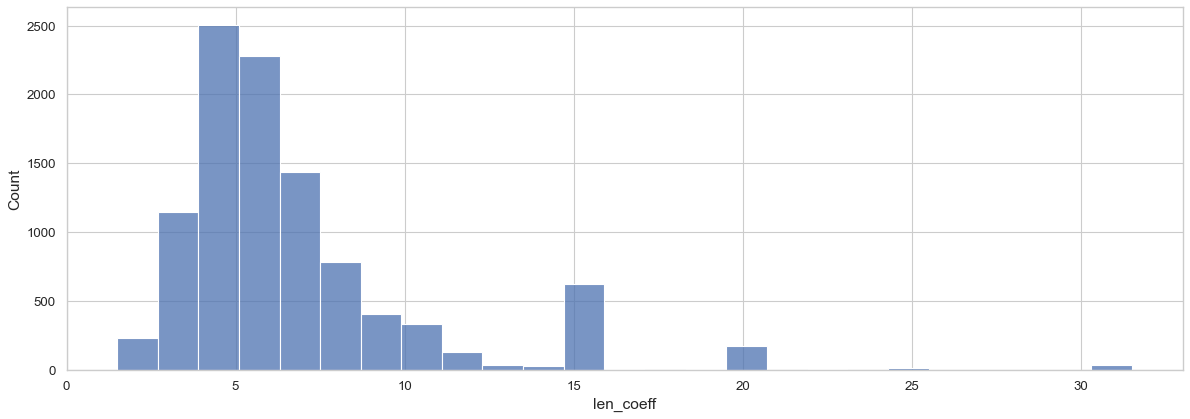

In [19]:
sns.histplot(df_sample['len_coeff'], bins=25)
plt.show()

In [20]:
cat_featering('top_domen')
cat_featering('2_domen')
cat_featering('3_domen')

In [21]:
cat_features = ['top_domen', '2_domen', '3_domen']#'status_code',
num_features = ['domen_len', 'len_coeff']

df_sample[cat_features] = df_sample[cat_features].astype('category')

In [22]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10178 entries, 0 to 10177
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   domen_name   10178 non-null  object  
 1   url          10178 non-null  object  
 2   label        10178 non-null  int64   
 3   status_code  10178 non-null  object  
 4   top_domen    10178 non-null  category
 5   2_domen      10178 non-null  category
 6   3_domen      10178 non-null  category
 7   domen_len    10178 non-null  int64   
 8   len_coeff    10178 non-null  float64 
dtypes: category(3), float64(1), int64(2), object(3)
memory usage: 567.9+ KB


In [23]:
df_sample

,domen_name,url,label,status_code,top_domen,2_domen,3_domen,domen_len,len_coeff
0,clientservices.googleapis.com,http://clientservices.googleapis.com,0,404,com,googleapis,OTHER,3,9.000000
1,ads.travelaudience.com,http://ads.travelaudience.com,1,None,com,OTHER,ads,3,6.666667
2,4d50bf49a3c12010ab594dff7964a3ca.safeframe.goo...,http://4d50bf49a3c12010ab594dff7964a3ca.safefr...,0,404,com,googlesyndication,safeframe,4,15.250000
3,c.whatsapp.net,http://c.whatsapp.net,1,None,net,whatsapp,c,3,4.000000
4,dmp.gotechnology.io,http://dmp.gotechnology.io,0,403,io,OTHER,dmp,3,5.666667
...,...,...,...,...,...,...,...,...,...
10173,www.superjob.ru,http://www.superjob.ru,0,200,ru,OTHER,www,3,4.333333
10174,tiktok-lb-maliva.byteoversea.net,http://tiktok-lb-maliva.byteoversea.net,0,404,net,byteoversea,OTHER,3,10.000000
10175,783419937.verify.yandex.ru,http://783419937.verify.yandex.ru,0,404,ru,yandex,verify,4,5.750000
10176,1442490661.verify.yandex.ru,http://1442490661.verify.yandex.ru,0,404,ru,yandex,verify,4,6.000000


## Разработка модели

### Features & Target

In [24]:
features = df_sample.drop(columns=['domen_name', 'url', 'label', 'status_code'])
target = df_sample['label']

### Train & Test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

### Подбор гипперпараметров модели

In [46]:
best_score = 0
estimators, learning_r = 0, 0
start_time = time.time()

for i in np.arange(140, 152, 1):
    for j in np.arange(0.64, 0.73, 0.01):
        model = CatBoostClassifier(n_estimators=i,
                                  learning_rate=j,
                                  depth=3,
                                  cat_features=cat_features,
                                  verbose=False,
                                  random_state=12345,
                                  )

        n_scores = cross_val_score(model,
                                   X_train,
                                   y_train,
                                   scoring='precision_macro',
                                   cv=5,
                                   n_jobs=-1,
                                   error_score='raise'
                                  )

        score = np.mean(np.abs(n_scores))

        if score > best_score:
            best_score = score
            estimators = i
            learning_r = j

fit_time = time.time() - start_time

display(HTML(f'<b>Гипперпараметры n_estimators:</b> <code>{estimators}</code>, <b>learning_rate:</b> <code>{learning_r:,.2f}</code>'))
display(HTML(f'<b>Лучший precision_score: </b> <code>{best_score:,.3f}</code>'))
display(HTML(f'<b>Время обучения: </b> <code>{fit_time:,.3f}</code> c'))

## Тестирование модели

In [47]:
model = CatBoostClassifier(n_estimators=estimators,
                          learning_rate=learning_r,
                          depth=3,
                          cat_features=cat_features,
                          verbose=False,
                          random_state=12345,
                         )
model.fit(X_train, y_train)
score_test = precision_score(y_test, model.predict(X_test), average='macro')

display(HTML(f'<b>precision_score на тестовой выборке: </b> <code>{score_test:,.3f}</code>'))

## Feature importances

In [48]:
fi = pd.DataFrame({'feature_importances':model.feature_importances_}, index=features.columns).sort_values(by='feature_importances', ascending=False)

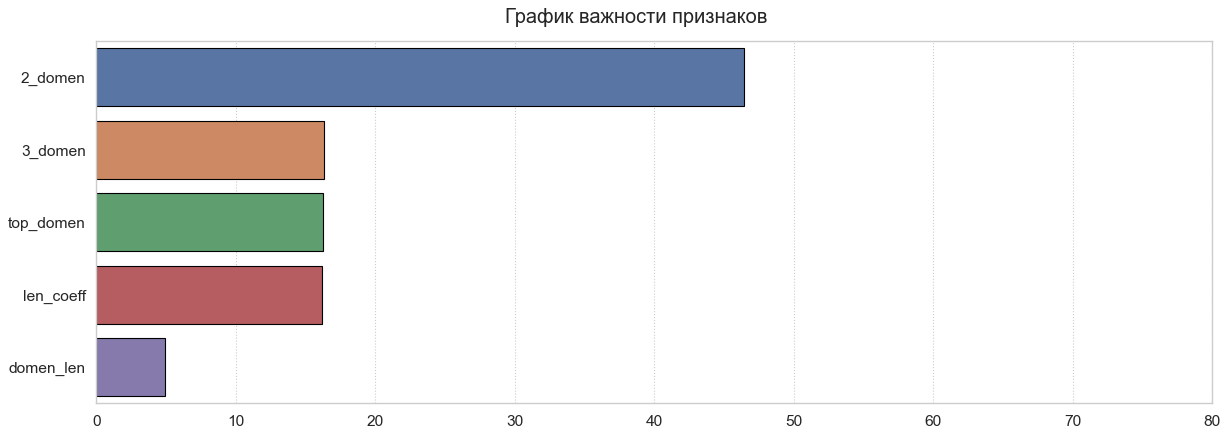

In [49]:
fig = plt.figure()
fig.suptitle(f'График важности признаков', x=.5, y=.95, fontsize=18)
sns.barplot(data=fi, x='feature_importances', y=fi.index, linewidth=1, edgecolor='black')
plt.grid(True, axis='x', linestyle=':', linewidth=1)
plt.tick_params(axis='both', direction='out', length=6, width=1)
plt.ylabel('')
plt.xlabel('')
plt.yticks(fontsize=14)
plt.xticks(list(range(0,90,10)), fontsize=14)
plt.show()